In [14]:
from pyspark.sql import SparkSession
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'secrets/serviceKey.json'


# JAR paths for BigQuery and GCS connectors
bigquery_connector_jar = "spark-bigquery-connector.jar"
gcs_connector_jar = "gcs-connector.jar"


# Create SparkSession with both connectors
spark = SparkSession.builder \
    .appName("PySpark with BigQuery and GCS") \
    .config("spark.jars", f"{bigquery_connector_jar},{gcs_connector_jar}") \
    .config("spark.sql.catalog.spark_bigquery", "com.google.cloud.spark.bigquery.BigQueryCatalog") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "secrets/serviceKey.json") \
    .config("spark.bigquery.projectId", "idmpproject-441123") \
    .getOrCreate()

spark

In [15]:
# Specify the BigQuery table
project_id = "idmpproject-441123"
dataset_id = "uberFareEstimation"
table_name = "uber_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
uber_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
uber_df.show()

+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|distance|cab_type|      time_stamp|       destination|       source|price|surge_multiplier|    id|    name|
+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|    0.94|    Uber|2018-11-28T23:00|         North End|North Station|  4.5|             1.0| 39765|UberPool|
|    0.94|    Uber|2018-12-14T19:00|         North End|North Station|  4.5|             1.0|437984|UberPool|
|    0.63|    Uber|2018-11-27T21:00|Financial District|South Station|  4.5|             1.0|  1644|UberPool|
|    0.63|    Uber|2018-12-15T15:00|Financial District|South Station|  4.5|             1.0| 10780|UberPool|
|    0.63|    Uber|2018-12-15T13:00|Financial District|South Station|  4.5|             1.0| 21598|UberPool|
|    0.63|    Uber|2018-11-28T20:00|Financial District|South Station|  4.5|             1.0| 25567|UberPool|
|    0.63|    Uber|

In [16]:
table_name = "lyft_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
lyft_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
lyft_df.show()

+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|distance|cab_type|      time_stamp|       destination|              source|price|surge_multiplier|    id|  name|
+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|     1.0|    Lyft|2018-12-02T10:00|Financial District|    Haymarket Square|  2.5|             1.0|266234|Shared|
|     1.0|    Lyft|2018-12-02T07:00|         North End|  Financial District|  2.5|             1.0|358706|Shared|
|     1.0|    Lyft|2018-12-17T02:00|Financial District|    Haymarket Square|  2.5|             1.0|401970|Shared|
|     1.0|    Lyft|2018-11-27T00:00|Financial District|    Haymarket Square|  2.5|             1.0|536179|Shared|
|     1.0|    Lyft|2018-12-16T19:00|     North Station|           North End|  2.5|             1.0|572308|Shared|
|    1.25|    Lyft|2018-12-14T09:00|          Back Bay|Northeastern Univ...|  2.5|      

In [17]:
table_name = "weather_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
weather_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
weather_df.show()

+-----+--------------------+------+--------+----+----------------+--------+----+
| temp|            location|clouds|pressure|rain|      time_stamp|humidity|wind|
+-----+--------------------+------+--------+----+----------------+--------+----+
|36.24|              Fenway|   0.0| 1012.38| 0.0|2018-12-16T12:00|    0.69|6.72|
|36.25|Northeastern Univ...|   0.0| 1012.38| 0.0|2018-12-13T23:00|    0.69|6.77|
|36.26|    Theatre District|   0.0| 1012.38| 0.0|2018-12-16T02:00|    0.69|6.86|
|36.26|            West End|   0.0| 1012.37| 0.0|2018-11-29T18:00|    0.69|6.84|
|29.97|            Back Bay|   0.0|  1015.2| 0.0|2018-11-29T03:00|    0.85|2.41|
|29.95|         Beacon Hill|   0.0| 1015.19| 0.0|2018-12-14T18:00|    0.85|2.43|
|29.85|   Boston University|   0.0|  1015.2| 0.0|2018-11-27T11:00|    0.85|2.33|
|29.83|              Fenway|   0.0|  1015.2| 0.0|2018-12-16T04:00|    0.85|2.35|
|29.98|  Financial District|   0.0| 1015.19| 0.0|2018-12-02T19:00|    0.85|2.48|
|29.99|    Haymarket Square|

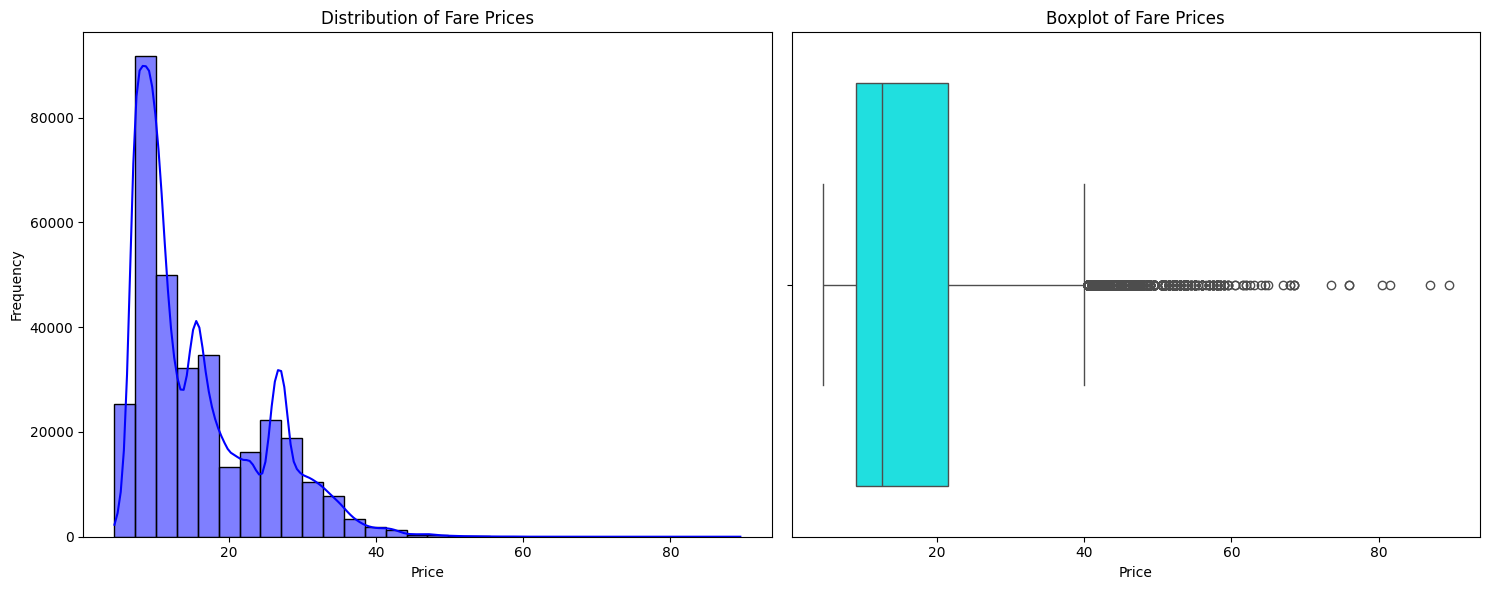

In [18]:
# Visualization 1 Fare price distribution (histogram and bar plot)

from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'price' column to Pandas for visualization
price_data_pd = uber_df.select("price").filter(col("price").isNotNull()).toPandas()

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram Plot
sns.histplot(price_data_pd['price'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Fare Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Boxplot Plot
sns.boxplot(x=price_data_pd['price'], color='cyan', ax=axes[1])
axes[1].set_title('Boxplot of Fare Prices')
axes[1].set_xlabel('Price')

# Display the plots
plt.tight_layout()
plt.show()


In [20]:
from pyspark.sql import functions as F

# Calculate Q1, Q3, and IQR
quantiles = uber_df.approxQuantile("price", [0.25, 0.75], 0.001)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1

# Calculate the upper bound (Q3 + 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Count the values beyond the upper bound
outliers_count = uber_df.filter(col("price") > upper_bound).count()

# Total number of values
total_count = uber_df.filter(col("price").isNotNull()).count()

# Calculate percentage of outliers
outliers_percentage = (outliers_count / total_count) * 100

# Print the results
print(f"Number of outliers beyond Q3 + 1.5 * IQR: {outliers_count}")
print(f"Percentage of outliers: {outliers_percentage:.2f}%")

Number of outliers beyond Q3 + 1.5 * IQR: 3015
Percentage of outliers: 0.91%


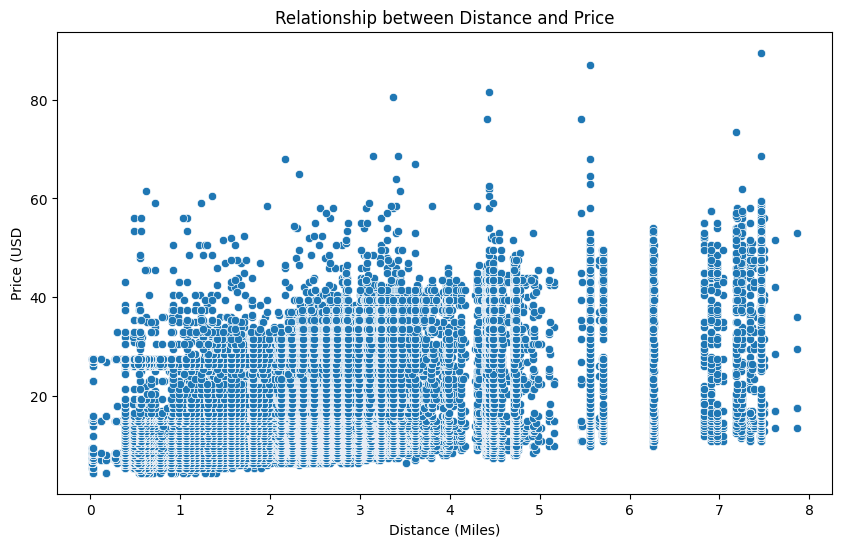

In [21]:
# Visualization 2 Distance vs Price (scatter plot)

distance_price_df_uber = uber_df.select('distance', 'price').toPandas()
distance_price_df_lyft = lyft_df.select('distance', 'price').toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=distance_price_df_uber['distance'], y=distance_price_df_uber['price'])
sns.scatterplot(x=distance_price_df_lyft['distance'], y=distance_price_df_lyft['price'])
plt.title('Relationship between Distance and Price')
plt.xlabel('Distance (Miles)')
plt.ylabel('Price (USD')
plt.show()

In [ ]:
# Visualization 3 (Surge multiplier impact on price (bar chart)

surge_mult_df = uber_df.select('surge_multiplier', 'price').toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x=surge_mult_df['surge_multiplier'], y=surge_mult_df['price'])
plt.title('Surge Multiplier Impact on Price (Uber)')
plt.xlabel('Surge Multiplier')
plt.ylabel('Price (USD)')
plt.show()


In [1]:
# Visualization 4 (Price vs weather conditions (heatmap)








